<a href="https://colab.research.google.com/github/CA683-Group99/Wind-Energy-Prediction/blob/main/4_IslandElectricity_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Colab is adapted from the [TensorFlow Time Series Tutorial ](https://www.tensorflow.org/tutorials/structured_data/time_series#advanced_autoregressive_model) to predict Ireland Wind Electricity Generation in the next 24 h : it implements a Long Short Term Memory (LSTM) and an Autoregressive Long Short Term Memory (LSTM). 

# Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/CA683Project')
# CL os.chdir('/content/drive/MyDrive/Colab Notebooks/CA683Project')

Mounted at /content/drive


In [2]:
import pandas as pd

inFilename = 'IslandElectricity2017_2020v4.csv'
filePath = 'Data/' + inFilename
inData = pd.read_csv(filePath)
#inData = pd.read_csv(inFilename)

print('-----------DATA INFO -------------')
print(inData.info())

display(inData.head())


inData.date = pd.to_datetime(inData.date, format='%Y-%m-%d %H:%M', errors='ignore')
inData.isweekday = inData.isweekday.astype('bool')

-----------DATA INFO -------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32136 entries, 0 to 32135
Data columns (total 77 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           32136 non-null  int64  
 1   date                 32136 non-null  object 
 2   rain_BEL             32136 non-null  float64
 3   temp_BEL             32136 non-null  float64
 4   wetb_BEL             32136 non-null  float64
 5   dewpt_BEL            32136 non-null  float64
 6   vappr_BEL            32136 non-null  float64
 7   rhum_BEL             32136 non-null  int64  
 8   msl_BEL              32136 non-null  float64
 9   wdsp_BEL             32136 non-null  int64  
 10  wddir_BEL            32136 non-null  int64  
 11  rain_DUB             32136 non-null  float64
 12  temp_DUB             32136 non-null  float64
 13  wetb_DUB             32136 non-null  float64
 14  dewpt_DUB            32136 non-null  float64
 15  v

,Unnamed: 0,date,rain_BEL,temp_BEL,wetb_BEL,dewpt_BEL,vappr_BEL,rhum_BEL,msl_BEL,wdsp_BEL,wddir_BEL,rain_DUB,temp_DUB,wetb_DUB,dewpt_DUB,vappr_DUB,rhum_DUB,msl_DUB,wdsp_DUB,wddir_DUB,ww_DUB,w_DUB,sun_DUB,vis_DUB,clht_DUB,clamt_DUB,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt,rain_COR,temp_COR,wetb_COR,dewpt_COR,vappr_COR,rhum_COR,msl_COR,wdsp_COR,wddir_COR,ww_COR,w_COR,sun_COR,vis_COR,clht_COR,clamt_COR,rain_MAL,temp_MAL,wetb_MAL,dewpt_MAL,vappr_MAL,rhum_MAL,msl_MAL,wdsp_MAL,wddir_MAL,Unnamed: 0.1,ActualDemandMW,ForecastWndMW,ActualWindMW,ActualGenerationMW,NetTotal_MW,WindMWPercent,hour,isweekday,month,year,TotalWindCapacityMW
0,0,2017-07-01 00:00:00,0.0,12.3,11.3,10.3,12.5,88,1017.6,8,200,0.0,8.5,7.4,6.2,9.4,85.0,1018.0,7,270,2,11,0.0,40000,999,1,0.0,10.6,9.5,8.4,11.0,86.0,1020.1,6,260,2,11,0.0,30000,999,0,0.0,10.0,8.7,7.2,10.2,83.0,1020.7,7,280,2,11,0.0,30000.0,999,2,0.0,9.9,8.7,7.3,10.2,84,1016.8,10,270.0,0.0,2394.75,287.0,280.25,2580.75,-221.00,11.702683,0.0,False,7.0,2017.0,4096.494
1,1,2017-07-01 01:00:00,0.0,12.5,11.4,10.4,12.6,87,1016.9,10,200,0.0,8.0,7.0,5.9,9.2,86.0,1018.2,9,270,2,11,0.0,40000,999,1,0.0,10.4,9.5,8.5,11.1,88.0,1019.8,4,240,2,11,0.0,30000,999,2,0.0,9.6,8.3,6.8,9.9,83.0,1020.5,7,280,2,11,0.0,30000.0,999,1,0.0,10.0,8.8,7.5,10.3,84,1016.2,10,260.0,1.0,2961.50,319.5,423.25,3402.00,-406.75,14.291744,1.0,False,7.0,2017.0,4096.494
2,2,2017-07-01 02:00:00,0.0,13.0,11.9,10.9,13.0,86,1016.2,14,200,0.0,7.5,6.9,6.2,9.5,91.0,1018.0,8,270,2,11,0.0,40000,999,1,0.0,10.0,9.5,9.0,11.5,93.0,1019.6,2,190,2,11,0.0,30000,999,2,0.0,9.7,8.4,7.0,10.0,83.0,1020.2,7,280,2,11,0.0,30000.0,999,1,0.0,10.0,9.2,8.3,10.9,88,1015.8,10,220.0,2.0,2785.25,320.0,451.25,3411.75,-388.00,16.201418,2.0,False,7.0,2017.0,4096.494
3,3,2017-07-01 03:00:00,0.0,12.9,12.0,11.2,13.3,89,1015.6,16,210,0.0,7.2,6.7,6.1,9.4,93.0,1018.0,9,270,2,11,0.0,60000,999,0,0.0,11.1,10.2,9.4,11.7,89.0,1018.8,5,190,2,11,0.0,20000,23,7,0.0,8.8,7.9,6.9,9.9,88.0,1019.9,4,280,2,11,0.0,30000.0,999,1,0.0,8.9,8.1,7.2,10.1,89,1015.4,10,190.0,3.0,2716.25,347.5,512.75,3500.00,-534.75,18.877128,3.0,False,7.0,2017.0,4096.494
4,4,2017-07-01 04:00:00,0.0,13.3,12.7,12.2,14.2,93,1015.0,17,210,0.0,7.6,7.0,6.3,9.5,91.0,1017.7,8,250,2,11,0.0,60000,999,1,0.0,11.5,10.4,9.4,11.7,86.0,1018.3,4,170,2,11,0.0,20000,23,7,0.0,8.5,7.6,6.6,9.7,88.0,1019.6,5,270,2,11,0.0,30000.0,18,5,0.0,8.7,7.9,7.0,10.0,89,1015.2,10,190.0,4.0,2654.00,410.5,576.75,3330.00,-430.50,21.731349,4.0,False,7.0,2017.0,4096.494


In [3]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

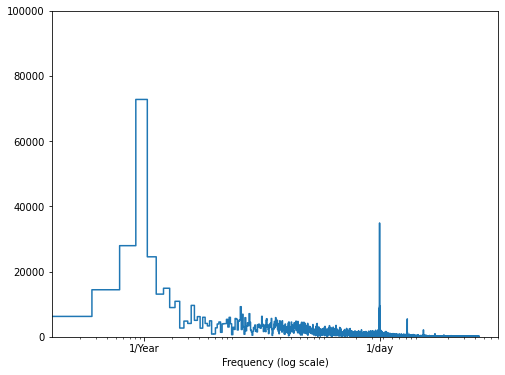

In [4]:
fft = tf.signal.rfft(inData['temp_DUB'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(inData['temp_DUB'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 100000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

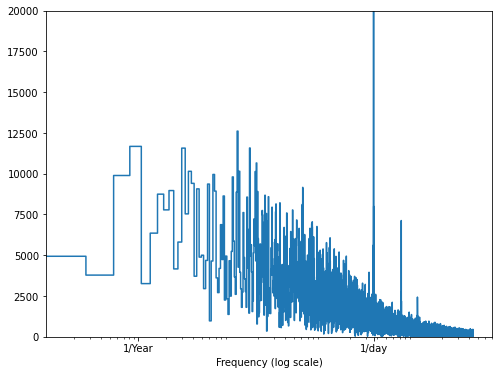

In [5]:
fft = tf.signal.rfft(inData['wdsp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(inData['wdsp'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 20000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

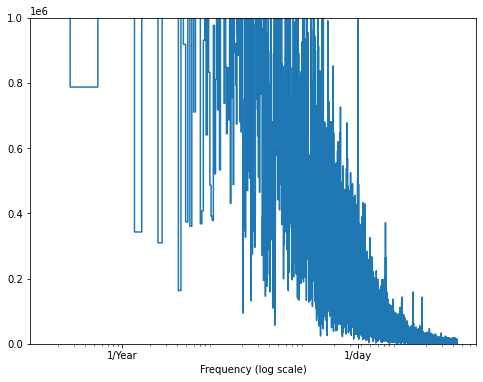

In [6]:
fft = tf.signal.rfft(inData['ActualWindMW'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(inData['ActualWindMW'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 1000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## Transform wind speed and dir into 2D wind vector

In [7]:
import math

suffixes = ['_COR', '_DUB', '_BEL', '', '_MAL']
def transformWindInto2d(df):
  for suf in suffixes:
    df['wind' + suf + 'sin'] = None
    df['wind' + suf + 'cos'] = None

  def transformWindInto2dRow(row):
    for suf in suffixes:
      row['wind' + suf + 'sin'] = row['wdsp'+ suf] * math.sin(row['wddir' + suf])
      row['wind' + suf + 'cos'] = row['wdsp'+ suf] * math.cos(row['wddir' + suf])
    return row

  df = df.apply(transformWindInto2dRow, axis='columns')
  return df

inData = transformWindInto2d(inData)
inData.columns

Index(['Unnamed: 0', 'date', 'rain_BEL', 'temp_BEL', 'wetb_BEL', 'dewpt_BEL',
       'vappr_BEL', 'rhum_BEL', 'msl_BEL', 'wdsp_BEL', 'wddir_BEL', 'rain_DUB',
       'temp_DUB', 'wetb_DUB', 'dewpt_DUB', 'vappr_DUB', 'rhum_DUB', 'msl_DUB',
       'wdsp_DUB', 'wddir_DUB', 'ww_DUB', 'w_DUB', 'sun_DUB', 'vis_DUB',
       'clht_DUB', 'clamt_DUB', 'rain', 'temp', 'wetb', 'dewpt', 'vappr',
       'rhum', 'msl', 'wdsp', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht',
       'clamt', 'rain_COR', 'temp_COR', 'wetb_COR', 'dewpt_COR', 'vappr_COR',
       'rhum_COR', 'msl_COR', 'wdsp_COR', 'wddir_COR', 'ww_COR', 'w_COR',
       'sun_COR', 'vis_COR', 'clht_COR', 'clamt_COR', 'rain_MAL', 'temp_MAL',
       'wetb_MAL', 'dewpt_MAL', 'vappr_MAL', 'rhum_MAL', 'msl_MAL', 'wdsp_MAL',
       'wddir_MAL', 'Unnamed: 0.1', 'ActualDemandMW', 'ForecastWndMW',
       'ActualWindMW', 'ActualGenerationMW', 'NetTotal_MW', 'WindMWPercent',
       'hour', 'isweekday', 'month', 'year', 'TotalWindCapacityMW',
       'wind_CORs

Text(0, 0.5, 'Wind Velocity [m/s]')

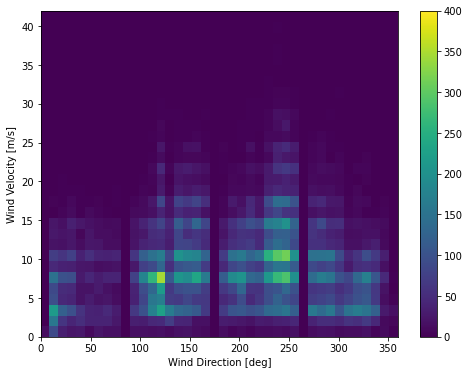

In [8]:
import matplotlib.pyplot as plt
plt.hist2d(inData['wddir'], inData['wdsp'], bins=(40, 30), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Text(0, 0.5, 'Wind Y')

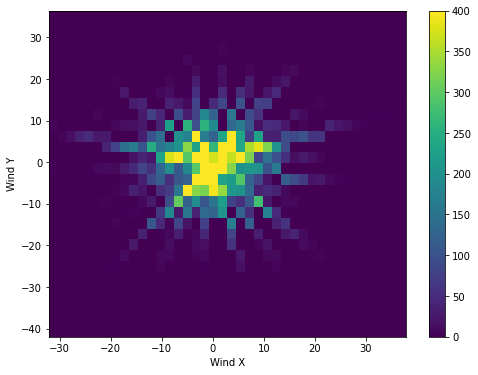

In [9]:
plt.hist2d(inData['windsin'], inData['windcos'], bins=(40, 30), vmax=400)
plt.colorbar()
plt.xlabel('Wind X')
plt.ylabel('Wind Y')

## Transform time into 2D

Intend to capture the seasonal pattern

In [10]:
import numpy as np
import math

def transformTimeInto2d(df):
  df['Day_inYear'] = None
  df['daysInYear'] = None
  df['radianTime'] = None
  df['radianTimeCos'] = None
  df['radianTimeSin'] = None

  def check_leap(year):
    if year%4 == 0:
      return 366
    else:
      return 365

  def transformTimeInto2dRow(row):
    row['Day_inYear'] = row['date'].timetuple().tm_yday
    daysInYear = check_leap(row['year'])
    row['daysInYear'] = daysInYear
    row['radianTime'] = (row.hour + row.Day_inYear * 24 ) / (24 * daysInYear) * (2*np.pi)
    row['radianTimeCos'] = math.cos(row['radianTime'])
    row['radianTimeSin'] = math.sin(row['radianTime'])
    return row

  df = df.apply(transformTimeInto2dRow, axis='columns')
  return df

inData = transformTimeInto2d(inData)
inData.columns

Index(['Unnamed: 0', 'date', 'rain_BEL', 'temp_BEL', 'wetb_BEL', 'dewpt_BEL',
       'vappr_BEL', 'rhum_BEL', 'msl_BEL', 'wdsp_BEL', 'wddir_BEL', 'rain_DUB',
       'temp_DUB', 'wetb_DUB', 'dewpt_DUB', 'vappr_DUB', 'rhum_DUB', 'msl_DUB',
       'wdsp_DUB', 'wddir_DUB', 'ww_DUB', 'w_DUB', 'sun_DUB', 'vis_DUB',
       'clht_DUB', 'clamt_DUB', 'rain', 'temp', 'wetb', 'dewpt', 'vappr',
       'rhum', 'msl', 'wdsp', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht',
       'clamt', 'rain_COR', 'temp_COR', 'wetb_COR', 'dewpt_COR', 'vappr_COR',
       'rhum_COR', 'msl_COR', 'wdsp_COR', 'wddir_COR', 'ww_COR', 'w_COR',
       'sun_COR', 'vis_COR', 'clht_COR', 'clamt_COR', 'rain_MAL', 'temp_MAL',
       'wetb_MAL', 'dewpt_MAL', 'vappr_MAL', 'rhum_MAL', 'msl_MAL', 'wdsp_MAL',
       'wddir_MAL', 'Unnamed: 0.1', 'ActualDemandMW', 'ForecastWndMW',
       'ActualWindMW', 'ActualGenerationMW', 'NetTotal_MW', 'WindMWPercent',
       'hour', 'isweekday', 'month', 'year', 'TotalWindCapacityMW',
       'wind_CORs

In [11]:
import plotly.express as px

fig = px.scatter(inData, x='Day_inYear', y='temp_DUB', color='year')
fig.show()

# Data preparation

## Select data for training and testing

In [12]:
# CL Change : take all data


# (inData.year<=2021)
dataSet = inData.loc[(inData.year>=2017) & (inData.date <= "2021-03-01"), ['date', 'hour', 'month', 'year', 'Day_inYear',
                                                                  'wdsp_BEL', 'wddir_BEL', 'wind_BELsin', 'wind_BELcos', 'vappr_BEL', 'rhum', 'temp_BEL',
                                                                  'wdsp', 'wddir', 'windsin', 'windcos', 'vappr', 'rhum', 'temp',
                                                                  'wdsp_COR', 'wddir_COR', 'wind_CORsin', 'wind_CORcos', 'vappr_COR', 'rhum_COR', 'temp_COR',
                                                                  'wdsp_DUB', 'wddir_DUB', 'wind_DUBsin', 'wind_DUBcos', 'vappr_DUB', 'rhum_DUB', 'temp_DUB',
                                                                  'wdsp_MAL', 'wddir_MAL', 'wind_MALsin', 'wind_MALcos',
                                                                  'TotalWindCapacityMW',
                                                                  'radianTimeSin', 'radianTimeCos',
                                                                  'ActualWindMW', 'ActualDemandMW', 'ForecastWndMW']]

In [13]:
dataSet.isnull().sum()

date                   0
hour                   0
month                  0
year                   0
Day_inYear             0
wdsp_BEL               0
wddir_BEL              0
wind_BELsin            0
wind_BELcos            0
vappr_BEL              0
rhum                   0
temp_BEL               0
wdsp                   0
wddir                  0
windsin                0
windcos                0
vappr                  0
rhum                   0
temp                   0
wdsp_COR               0
wddir_COR              0
wind_CORsin            0
wind_CORcos            0
vappr_COR              0
rhum_COR               0
temp_COR               0
wdsp_DUB               0
wddir_DUB              0
wind_DUBsin            0
wind_DUBcos            0
vappr_DUB              0
rhum_DUB               0
temp_DUB               0
wdsp_MAL               0
wddir_MAL              0
wind_MALsin            0
wind_MALcos            0
TotalWindCapacityMW    0
radianTimeSin          0
radianTimeCos          0


## Different feature sets to build different models

In [14]:
# CL: 2021/04/02: remove Hour as very highly correlated with Day_inYear, as well as temp other than temp_DUB
# and add 'msl' Sea Level pressure as highly predictive of upcoming storm and improve wind turbine performance
# add Malin Head wind
# CL: 2021/04/02: remove Hour as very highly correlated with Day_inYear, as well as temp other than temp_DUB
# and add 'msl' Sea Level pressure as highly predictive of upcoming storm and improve wind turbine performance
attr_basic = ['hour', 'Day_inYear',
              'wdsp_BEL', 'wddir_BEL', 
              'wdsp', 'wddir', 'msl',
              'wdsp_COR', 'wddir_COR',
              'wdsp_DUB', 'wddir_DUB', 'temp_DUB',
              'wdsp_MAL', 'wddir_MAL',
              'TotalWindCapacityMW']

attr_rhum = ['hour', 'Day_inYear',
              'wdsp_BEL', 'wddir_BEL', 'rhum', 
              'wdsp', 'wddir', 'rhum', 'msl',
              'wdsp_COR', 'wddir_COR', 'rhum_COR',
              'wdsp_DUB', 'wddir_DUB', 'rhum_DUB', 'temp_DUB',
              'wdsp_MAL', 'wddir_MAL',
              'TotalWindCapacityMW']

attr_vappr = ['hour', 'Day_inYear',
              'wdsp_BEL', 'wddir_BEL', 'vappr_BEL', 
              'wdsp', 'wddir', 'vappr','msl', 
              'wdsp_COR', 'wddir_COR', 'vappr_COR',
              'wdsp_DUB', 'wddir_DUB', 'vappr_DUB', 'temp_DUB',
              'wdsp_MAL', 'wddir_MAL',
              'TotalWindCapacityMW']

attr_rhum_vappr = ['hour', 'Day_inYear',
                    'wdsp_BEL', 'wddir_BEL', 'rhum', 'vappr_BEL', 
                    'wdsp', 'wddir', 'rhum', 'vappr', 'msl',
                    'wdsp_COR', 'wddir_COR', 'rhum_COR', 'vappr_COR',
                    'wdsp_DUB', 'wddir_DUB', 'rhum_DUB', 'vappr_DUB', 'temp_DUB',
                    'wdsp_MAL', 'wddir_MAL',
                    'TotalWindCapacityMW']

attr_2D_wind = ['hour', 'Day_inYear',
                'wind_BELsin', 'wind_BELcos', 
                'windsin', 'windcos', 'msl',
                'wind_CORsin', 'wind_CORcos',
                'wind_DUBsin', 'wind_DUBcos', 'temp_DUB',
                'wind_MALsin', 'wind_MALcos',
                'TotalWindCapacityMW']

attr_radianTime = ['hour', 'wdsp_BEL', 'wddir_BEL', 
                    'wdsp', 'wddir', 'msl',
                    'wdsp_COR', 'wddir_COR',
                    'wdsp_DUB', 'wddir_DUB', 'temp_DUB',
                    'wdsp_MAL', 'wddir_MAL',
                    'radianTimeSin', 'radianTimeCos',
                    'TotalWindCapacityMW']

attr_2D_wind_time = ['hour', 'wind_BELsin', 'wind_BELcos', 
                      'windsin', 'windcos', 'msl',
                      'wind_CORsin', 'wind_CORcos', 
                      'wind_DUBsin', 'wind_DUBcos', 'temp_DUB', 
                      'wind_MALsin', 'wind_MALcos',
                      'radianTimeSin', 'radianTimeCos',
                      'TotalWindCapacityMW']


attr_selections = [attr_basic, attr_rhum, attr_vappr, attr_rhum_vappr, attr_2D_wind, attr_radianTime, attr_2D_wind_time]
attrSet_names = ['basic', 'rhum', 'vappr', 'rhum & vappr', 'wind', 'radianTime', 'wind & time']





## Handle the rows with empty values

In [15]:
# CL Change : check no missing value
dataSet.isnull().sum()

date                   0
hour                   0
month                  0
year                   0
Day_inYear             0
wdsp_BEL               0
wddir_BEL              0
wind_BELsin            0
wind_BELcos            0
vappr_BEL              0
rhum                   0
temp_BEL               0
wdsp                   0
wddir                  0
windsin                0
windcos                0
vappr                  0
rhum                   0
temp                   0
wdsp_COR               0
wddir_COR              0
wind_CORsin            0
wind_CORcos            0
vappr_COR              0
rhum_COR               0
temp_COR               0
wdsp_DUB               0
wddir_DUB              0
wind_DUBsin            0
wind_DUBcos            0
vappr_DUB              0
rhum_DUB               0
temp_DUB               0
wdsp_MAL               0
wddir_MAL              0
wind_MALsin            0
wind_MALcos            0
TotalWindCapacityMW    0
radianTimeSin          0
radianTimeCos          0


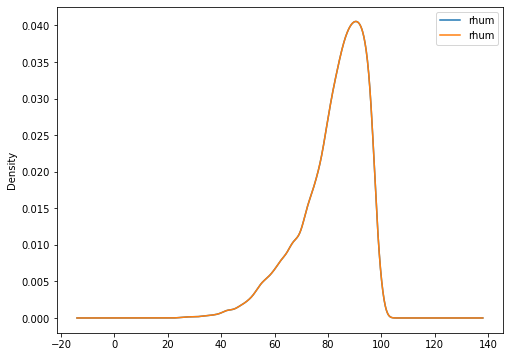

In [16]:
dataSet.rhum.plot.density()

dataSet.fillna(method='ffill', inplace=True)

In [17]:
# dataSet.fillna(method='ffill', limit=4, inplace=True)

# Remove the rows with empty cells
import numpy as np
eIdx = np.where(pd.isnull(dataSet))
print(eIdx[0])

print(dataSet.shape)
dataSet = dataSet.drop(eIdx[0], axis=0)
print(dataSet.shape)

[]
(32136, 43)
(32136, 43)


In [114]:
# CL END CHANGE 

# Training, Validation & Test set

In [115]:
from sklearn.model_selection import train_test_split

# Need continous time windows for LSTM, so commenting out
if (False):
  dataSet["dayInMonth"] = 0

  def setDayInMonth(row):
      row["dayInMonth"] = row.date.day
      return row

  dataSet = dataSet.apply(setDayInMonth, axis=1)

  trainSet = dataSet.loc[(dataSet.dayInMonth > 0) & (dataSet.dayInMonth < 23), :]
  validSet = dataSet.loc[(dataSet.dayInMonth >= 23), :]

  # # trainSet, validSet = train_test_split(dataSet, test_size=0.2, random_state=42)

  # import numpy as np
  # monthYear = []
  # for y in range(2017,2021):
  #   for m in range(1,13):
  #     monthYear.append([m, y])
  # trainDate, validDate = train_test_split(monthYear, test_size=0.2, random_state=42)

  # trainDate = np.array(trainDate)
  # validDate = np.array(validDate)

  # trainSet = dataSet.loc[(dataSet.month in trainDate[:,0]) & (dataSet.year in trainDate[:,1]), :]
  # validSet = dataSet.loc[(dataSet.month in validDate[:,0]) & (dataSet.year in validDate[:,1]), :]

  y_train = trainSet.ActualWindMW
  y_valid = validSet.ActualWindMW

In [18]:
# split
column_indices = {name: i for i, name in enumerate(dataSet.columns)}

n = len(dataSet)
trainSet = dataSet[0:int(n*0.7)]
validSet = dataSet[int(n*0.7):int(n*0.9)]
testSet = dataSet[int(n*0.9):]

num_features = dataSet.shape[1]

y_train = trainSet.ActualWindMW
y_valid = validSet.ActualWindMW
y_test = testSet.ActualWindMW

In [19]:
trainSet.shape, validSet.shape, testSet.shape

((22495, 43), (6427, 43), (3214, 43))

In [20]:
testSet

,date,hour,month,year,Day_inYear,wdsp_BEL,wddir_BEL,wind_BELsin,wind_BELcos,vappr_BEL,rhum,temp_BEL,wdsp,wddir,windsin,windcos,vappr,rhum,temp,wdsp_COR,wddir_COR,wind_CORsin,wind_CORcos,vappr_COR,rhum_COR,temp_COR,wdsp_DUB,wddir_DUB,wind_DUBsin,wind_DUBcos,vappr_DUB,rhum_DUB,temp_DUB,wdsp_MAL,wddir_MAL,wind_MALsin,wind_MALcos,TotalWindCapacityMW,radianTimeSin,radianTimeCos,ActualWindMW,ActualDemandMW,ForecastWndMW
28922,2020-10-18 02:00:00,2.0,10.0,2020.0,292,7,90,6.257977,-3.136515,8.7,84.0,6.8,6,60,-1.828864,-5.714478,9.3,84.0,8.6,10,120,5.806112,8.141810,11.2,86.0,10.9,2,260,1.366479,-1.460388,7.5,98.0,3.1,9,40.0,6.706018,-6.002443,5531.095,-0.954786,0.297293,1090.00,3194.25,1065.75
28923,2020-10-18 03:00:00,3.0,10.0,2020.0,292,6,90,5.363980,-2.688442,9.3,85.0,7.7,6,60,-1.828864,-5.714478,9.3,85.0,8.3,9,120,5.225501,7.327629,10.7,82.0,10.8,2,330,-0.264763,-1.982398,7.0,98.0,2.2,7,90.0,6.257977,-3.136515,5531.095,-0.954573,0.297976,1056.75,3098.00,986.50
28924,2020-10-18 04:00:00,4.0,10.0,2020.0,292,4,70,3.095563,2.533277,9.0,86.0,7.5,4,60,-1.219242,-3.809652,9.3,86.0,8.1,9,120,5.225501,7.327629,11.1,85.0,10.9,1,20,0.912945,0.408082,6.8,98.0,1.8,4,110.0,-0.176971,-3.996083,5531.095,-0.954360,0.298659,1019.50,3060.25,917.50
28925,2020-10-18 05:00:00,5.0,10.0,2020.0,292,5,90,4.469983,-2.240368,8.1,85.0,5.6,5,70,3.869453,3.166596,9.4,85.0,8.5,10,120,5.806112,8.141810,11.6,89.0,10.9,2,360,1.917831,-0.567382,7.0,100.0,1.9,4,120.0,2.322445,3.256724,5531.095,-0.954146,0.299341,950.00,3080.75,878.50
28926,2020-10-18 06:00:00,6.0,10.0,2020.0,292,6,90,5.363980,-2.688442,8.9,86.0,6.8,8,110,-0.353941,-7.992167,9.8,86.0,8.9,9,100,-4.557291,7.760870,11.6,89.0,11.0,2,60,-0.609621,-1.904826,6.9,98.0,2.0,4,140.0,3.920959,-0.791254,5531.095,-0.953932,0.300024,885.25,3207.25,849.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32131,2021-02-28 19:00:00,19.0,2.0,2021.0,59,4,360,3.835663,-1.134764,7.2,66.0,5.1,3,60,-0.914432,-2.857239,6.9,66.0,7.6,6,80,-5.963332,-0.662323,8.6,95.0,5.5,7,80,-6.957221,-0.772711,8.2,89.0,5.7,9,130.0,-8.370954,-3.305622,5531.095,0.856921,0.515448,571.75,5288.00,602.50
32132,2021-02-28 20:00:00,20.0,2.0,2021.0,59,2,10,-1.088042,-1.678143,6.9,75.0,3.8,4,50,-1.049499,3.859864,6.7,75.0,5.3,7,70,5.417235,4.433234,8.4,95.0,5.1,6,80,-5.963332,-0.662323,7.5,87.0,4.8,7,150.0,-5.004135,4.894756,5531.095,0.857290,0.514833,809.75,4913.25,719.00
32133,2021-02-28 21:00:00,21.0,2.0,2021.0,59,5,360,4.794579,-1.418455,7.0,81.0,3.4,4,50,-1.049499,3.859864,6.8,81.0,4.5,8,60,-2.438485,-7.619304,7.8,90.0,4.9,5,100,-2.531828,4.311594,7.7,100.0,3.3,5,200.0,-4.366486,2.435938,5531.095,0.857659,0.514218,976.75,4540.50,782.75
32134,2021-02-28 22:00:00,22.0,2.0,2021.0,59,3,40,2.235339,-2.000814,6.9,88.0,2.9,1,70,0.773891,0.633319,6.6,88.0,3.0,8,80,-7.951109,-0.883098,7.5,87.0,4.9,5,100,-2.531828,4.311594,7.0,96.0,2.4,6,160.0,1.316552,-5.853776,5531.095,0.858028,0.513603,1039.25,4156.75,776.75


In [118]:
y_test

28922    1090.00
28923    1056.75
28924    1019.50
28925     950.00
28926     885.25
          ...   
32131     571.75
32132     809.75
32133     976.75
32134    1039.25
32135    1034.00
Name: ActualWindMW, Length: 3214, dtype: float64

## Basic subset

In [119]:
attr_basic_set = ['hour', 'Day_inYear',
              'wdsp_BEL', 'wddir_BEL', 'temp_BEL',
              'wdsp', 'wddir',
              'wdsp_COR', 'wddir_COR',
              'wdsp_DUB', 'wddir_DUB', 'temp_DUB',
              'wdsp_MAL', 'wddir_MAL',
              'TotalWindCapacityMW', 'ActualWindMW']

In [120]:
# Scale data
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder


X_train = trainSet.loc[:, attr_basic_set]
X_valid = validSet.loc[:, attr_basic_set]
X_test = testSet.loc[:, attr_basic_set]

column_indices = {name: i for i, name in enumerate(X_train.columns)}
num_features = X_train.shape[1]

ct = make_column_transformer((StandardScaler(), attr_basic_set))
ct.fit(X_train)

train_df = pd.DataFrame(ct.transform(X_train), columns=X_train.columns)

val_df =  pd.DataFrame(ct.transform(X_valid), columns=X_train.columns) 
test_df = pd.DataFrame(ct.transform(X_test), columns=X_train.columns) 


In [121]:
actualWindScaler = StandardScaler()
actualWindScaler.fit(X_train.loc[:, ['ActualWindMW']])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [122]:
actualWindScaler.mean_, actualWindScaler.var_

(array([1272.8389531]), array([863195.23061257]))

In [123]:
actualWindScaler.transform(X_test.loc[:, ['ActualWindMW']])

array([[-0.19679507],
       [-0.23258304],
       [-0.27267634],
       ...,
       [-0.31868945],
       [-0.25141882],
       [-0.25706955]])

In [124]:
(976.75 - actualWindScaler.mean_) / np.sqrt(actualWindScaler.var_)

array([-0.31868945])

In [125]:
X_test.ActualWindMW

28922    1090.00
28923    1056.75
28924    1019.50
28925     950.00
28926     885.25
          ...   
32131     571.75
32132     809.75
32133     976.75
32134    1039.25
32135    1034.00
Name: ActualWindMW, Length: 3214, dtype: float64

In [126]:
scaler = ct.named_transformers_['standardscaler']
scaler.inverse_transform(test_df)

array([[2.000000e+00, 2.920000e+02, 7.000000e+00, ..., 4.000000e+01,
        5.531095e+03, 1.090000e+03],
       [3.000000e+00, 2.920000e+02, 6.000000e+00, ..., 9.000000e+01,
        5.531095e+03, 1.056750e+03],
       [4.000000e+00, 2.920000e+02, 4.000000e+00, ..., 1.100000e+02,
        5.531095e+03, 1.019500e+03],
       ...,
       [2.100000e+01, 5.900000e+01, 5.000000e+00, ..., 2.000000e+02,
        5.531095e+03, 9.767500e+02],
       [2.200000e+01, 5.900000e+01, 3.000000e+00, ..., 1.600000e+02,
        5.531095e+03, 1.039250e+03],
       [2.300000e+01, 5.900000e+01, 4.000000e+00, ..., 1.500000e+02,
        5.531095e+03, 1.034000e+03]])

In [127]:
train_df.shape, val_df.shape, test_df.shape

((22495, 16), (6427, 16), (3214, 16))

In [128]:
num_features

16

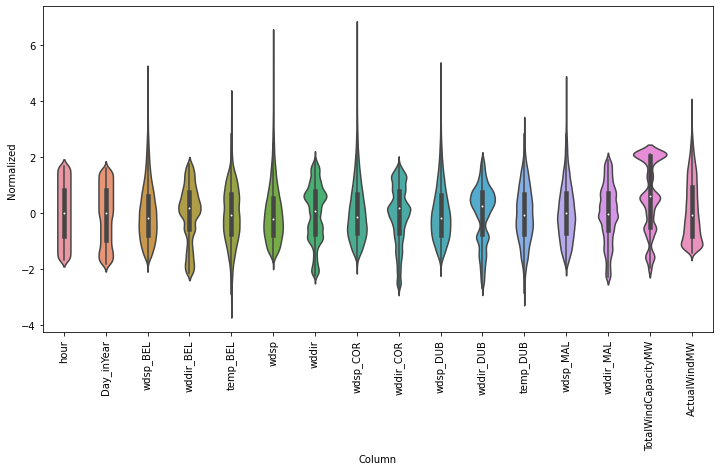

In [129]:
df = dataSet.loc[:, attr_basic_set]


df_std = pd.DataFrame(ct.transform(df))
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data windowing

In [130]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [131]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['ActualWindMW'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['ActualWindMW']

In [132]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['ActualWindMW'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['ActualWindMW']

In [133]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [134]:
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['ActualWindMW']

In [135]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])




In [136]:
train_df[:w2.total_window_size]

,hour,Day_inYear,wdsp_BEL,wddir_BEL,temp_BEL,wdsp,wddir,wdsp_COR,wddir_COR,wdsp_DUB,wddir_DUB,temp_DUB,wdsp_MAL,wddir_MAL,TotalWindCapacityMW,ActualWindMW
0,-1.660790,-0.136284,-0.627293,-0.036334,0.434301,-0.600563,0.779427,-0.524066,0.774625,-0.574512,0.763662,-0.295224,-0.705521,0.813517,-1.976297,-1.068353
1,-1.516340,-0.136284,-0.323459,-0.036334,0.484475,-0.983772,0.545736,-0.524066,0.774625,-0.167558,0.763662,-0.392668,-0.705521,0.694030,-1.976297,-0.914438
2,-1.371891,-0.136284,0.284208,-0.036334,0.609912,-1.366981,-0.038490,-0.524066,0.774625,-0.371035,0.763662,-0.490111,-0.705521,0.216081,-1.976297,-0.884301
3,-1.227441,-0.136284,0.588042,0.074446,0.584824,-0.792167,-0.038490,-1.116222,0.774625,-0.167558,0.763662,-0.548577,-0.705521,-0.142381,-1.976297,-0.818107
4,-1.082991,-0.136284,0.739959,0.074446,0.685173,-0.983772,-0.272180,-0.918837,0.651455,-0.371035,0.509383,-0.470622,-0.705521,-0.142381,-1.976297,-0.749221
5,-0.938541,-0.136284,0.284208,0.074446,0.710261,-0.600563,-0.155335,-1.313608,0.158772,-0.167558,0.509383,-0.392668,-0.845580,-0.261868,-1.976297,-0.696212
6,-0.794092,-0.136284,0.284208,0.074446,0.760435,-0.792167,-0.272180,-1.116222,0.035601,0.035919,0.509383,-0.158803,-0.425402,-0.142381,-1.976297,-0.616295


In [137]:
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 16)
Inputs shape: (3, 6, 16)
labels shape: (3, 1, 1)


In [138]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=float64, numpy=
array([[[-0.61629472]],

       [[-1.35923157]],

       [[-0.81891386]]])>

In [139]:
w2.example = example_inputs, example_labels

In [140]:
def plot(self, model=None, plot_col='ActualWindMW', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

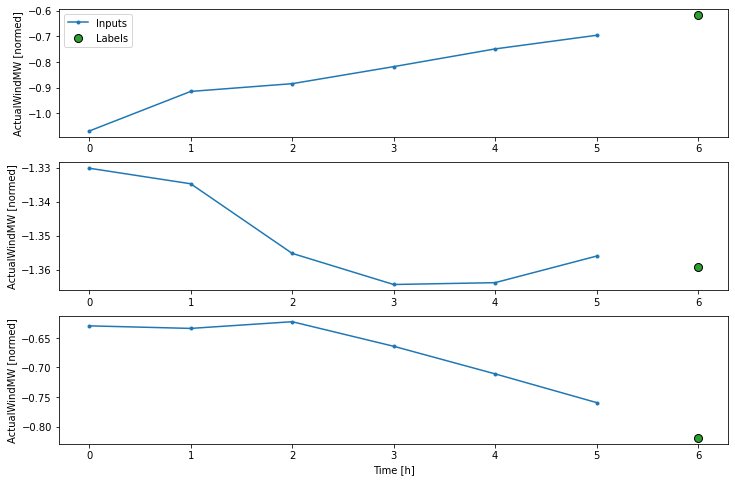

In [141]:
w2.plot()

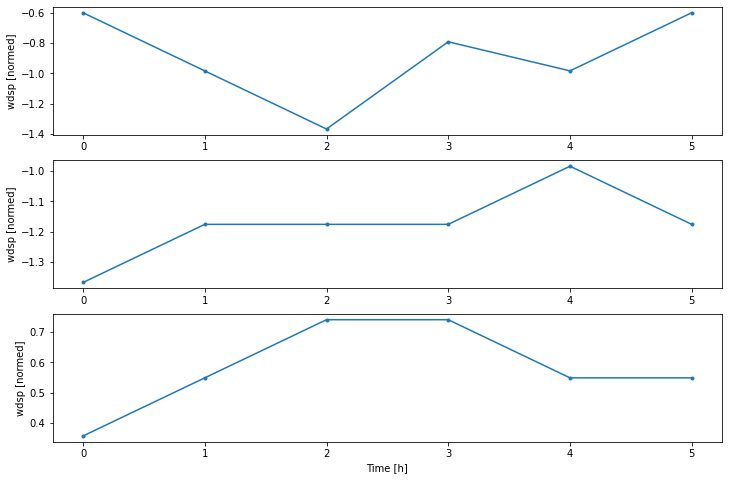

In [142]:
w2.plot(plot_col='wdsp')

In [143]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [144]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [145]:
type(w2.train)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [146]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 16), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [147]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 16)
Labels shape (batch, time, features): (32, 1, 1)


In [148]:
w2.input_indices, w2.label_columns_indices

(array([0, 1, 2, 3, 4, 5]), {'ActualWindMW': 0})

# Single step model

In [149]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['ActualWindMW'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['ActualWindMW']

In [150]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 16)
Labels shape (batch, time, features): (32, 1, 1)


In [151]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['ActualWindMW'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['ActualWindMW']

In [152]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 16)
Labels shape (batch, time, features): (32, 24, 1)


## Baseline model : copy previous value!

In [153]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [154]:
baseline = Baseline(label_index=column_indices['ActualWindMW'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

201/201 [==============================] - 1s 3ms/step - loss: 0.0258 - mean_absolute_error: 0.1128


In [155]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 16)
Output shape: (32, 24, 1)


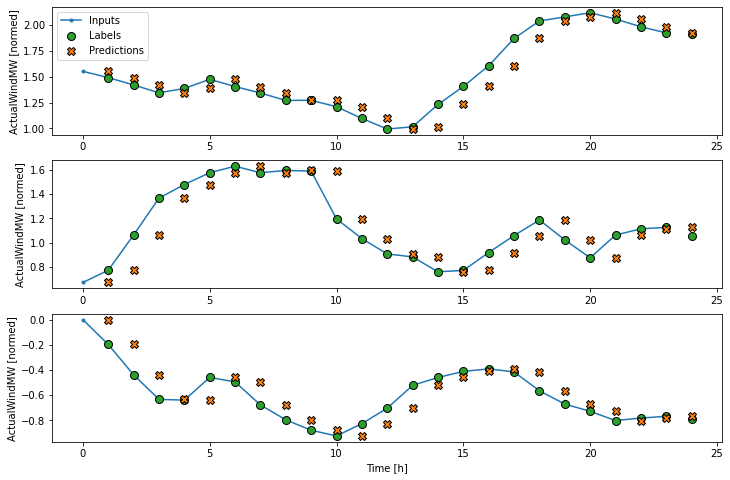

In [156]:
wide_window.plot(baseline)

## Linear model

In [157]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [158]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [159]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
703/703 [==============================] - 4s 5ms/step - loss: 0.8381 - mean_absolute_error: 0.6947 - val_loss: 0.1583 - val_mean_absolute_error: 0.3108
Epoch 2/20
703/703 [==============================] - 3s 4ms/step - loss: 0.0880 - mean_absolute_error: 0.2268 - val_loss: 0.0519 - val_mean_absolute_error: 0.1724
Epoch 3/20
703/703 [==============================] - 3s 5ms/step - loss: 0.0359 - mean_absolute_error: 0.1430 - val_loss: 0.0305 - val_mean_absolute_error: 0.1300
Epoch 4/20
703/703 [==============================] - 3s 5ms/step - loss: 0.0227 - mean_absolute_error: 0.1105 - val_loss: 0.0252 - val_mean_absolute_error: 0.1149
Epoch 5/20
703/703 [==============================] - 3s 5ms/step - loss: 0.0199 - mean_absolute_error: 0.1012 - val_loss: 0.0246 - val_mean_absolute_error: 0.1125
Epoch 6/20
703/703 [==============================] - 3s 5ms/step - loss: 0.0195 - mean_absolute_error: 0.0997 - val_loss: 0.0246 - val_mean_absolute_error: 0.1126
Epoch 7/20
201/2

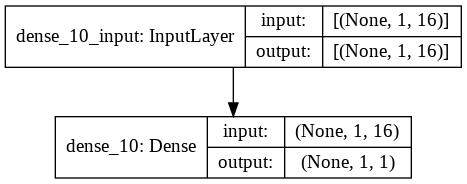

In [160]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(linear, to_file='linear_model.png', show_shapes=True, show_layer_names=True)

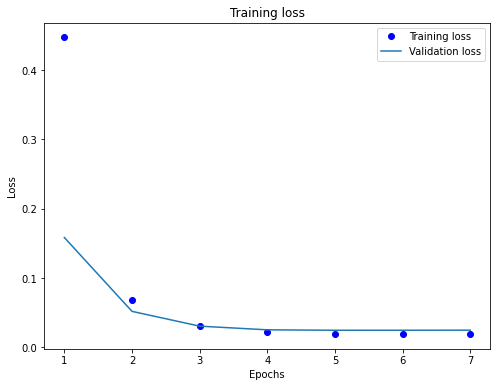

In [161]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss, label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [162]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 16)
Output shape: (32, 24, 1)


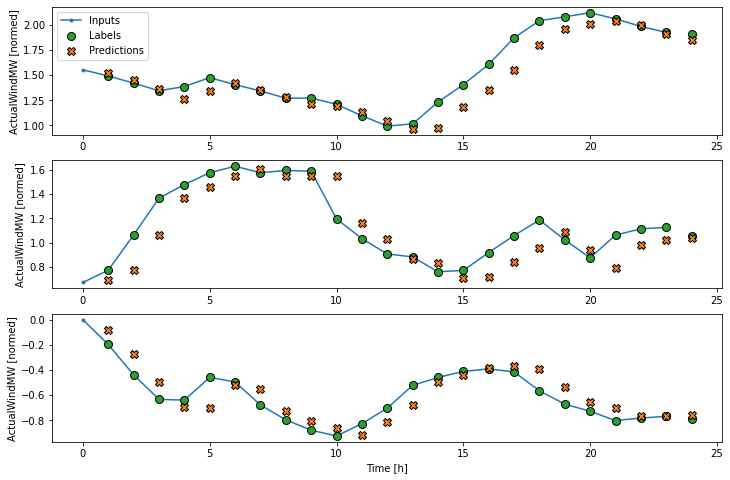

In [163]:
wide_window.plot(linear)

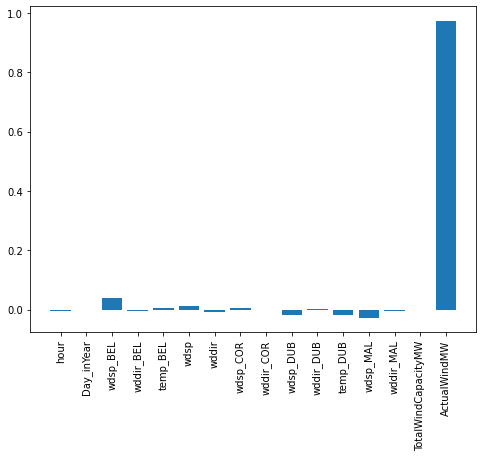

In [164]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense sequential

In [165]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
703/703 [==============================] - 4s 5ms/step - loss: 0.1037 - mean_absolute_error: 0.2127 - val_loss: 0.0422 - val_mean_absolute_error: 0.1567
Epoch 2/20
703/703 [==============================] - 4s 5ms/step - loss: 0.0217 - mean_absolute_error: 0.1100 - val_loss: 0.0358 - val_mean_absolute_error: 0.1401
Epoch 3/20
703/703 [==============================] - 4s 5ms/step - loss: 0.0190 - mean_absolute_error: 0.1016 - val_loss: 0.0275 - val_mean_absolute_error: 0.1223
Epoch 4/20
703/703 [==============================] - 4s 5ms/step - loss: 0.0179 - mean_absolute_error: 0.0982 - val_loss: 0.0445 - val_mean_absolute_error: 0.1531
Epoch 5/20
703/703 [==============================] - 4s 5ms/step - loss: 0.0177 - mean_absolute_error: 0.0977 - val_loss: 0.0262 - val_mean_absolute_error: 0.1179
Epoch 6/20
703/703 [==============================] - 4s 5ms/step - loss: 0.0166 - mean_absolute_error: 0.0941 - val_loss: 0.0320 - val_mean_absolute_error: 0.1299
Epoch 7/20
201/2

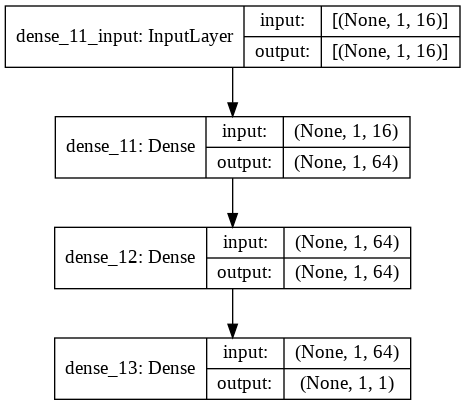

In [166]:
from tensorflow.python.keras.utils.vis_utils import plot_model

plot_model(dense, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


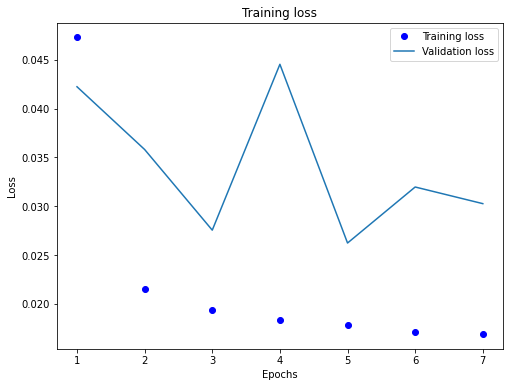

In [167]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss, label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

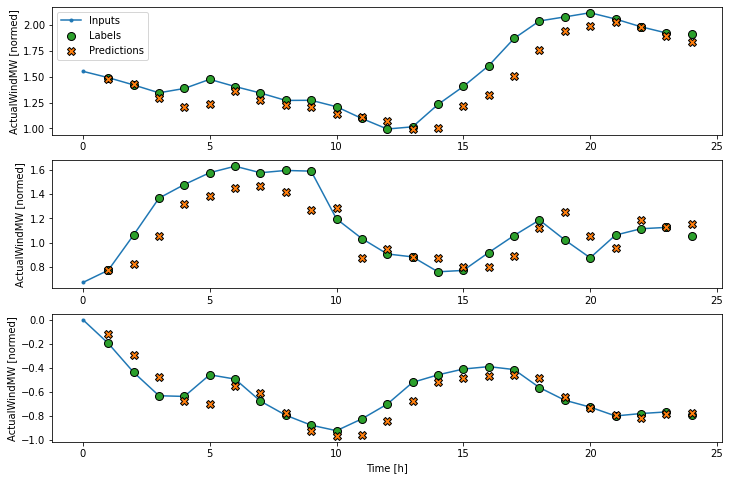

In [168]:
wide_window.plot(dense)

## LTSM

In [169]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [170]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 16)
Output shape: (32, 24, 1)


In [171]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

201/201 [==============================] - 1s 5ms/step - loss: 0.0155 - mean_absolute_error: 0.0888


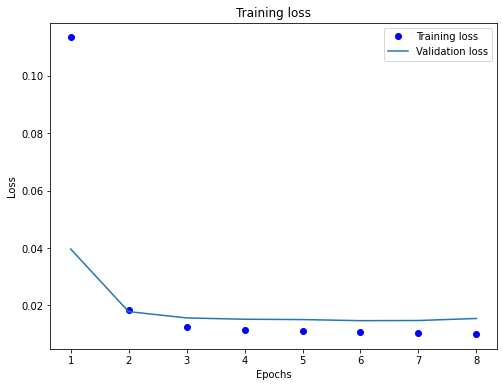

In [172]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss, label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

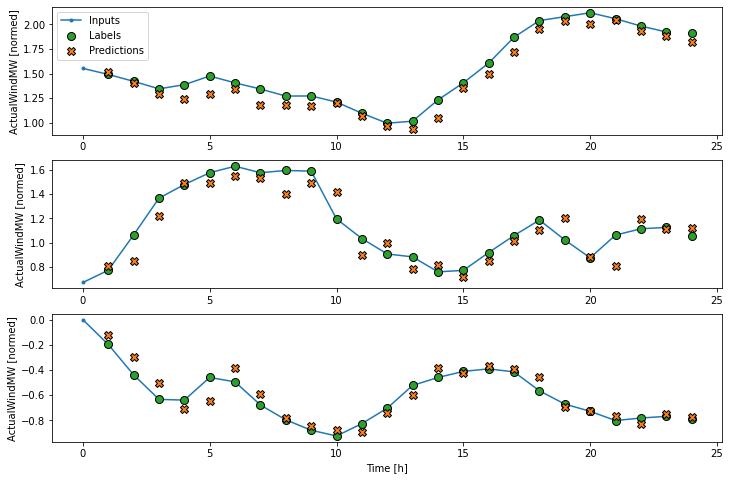

In [173]:
wide_window.plot(lstm_model)

### Performance

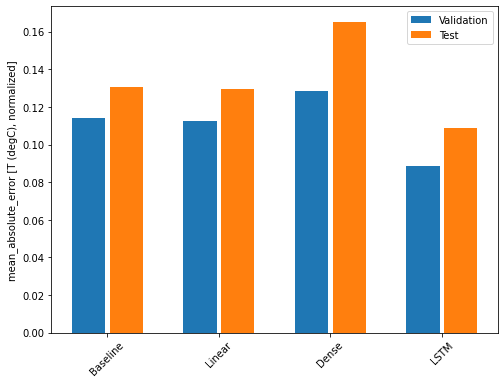

In [174]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

# Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, 1h into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

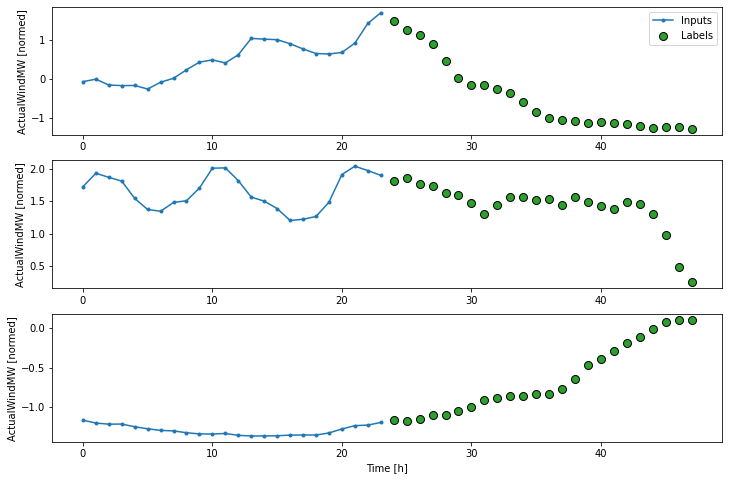

In [175]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baseline

200/200 [==============================] - 1s 3ms/step - loss: 0.9442 - mean_absolute_error: 0.6203


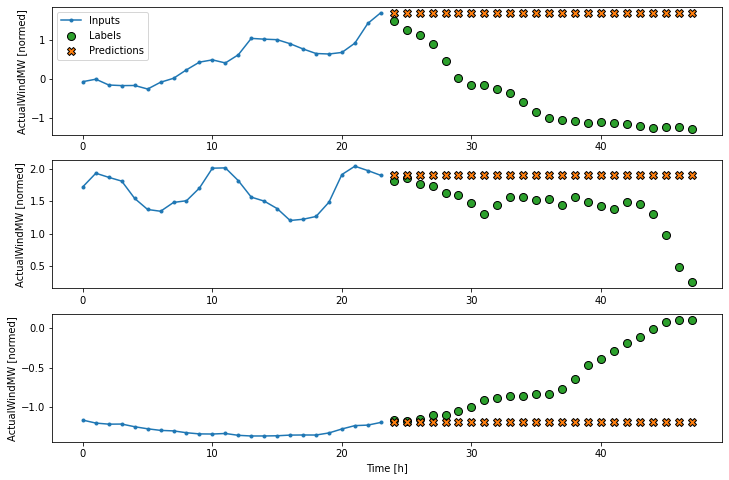

In [176]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

200/200 [==============================] - 1s 4ms/step - loss: 1.0505 - mean_absolute_error: 0.6499


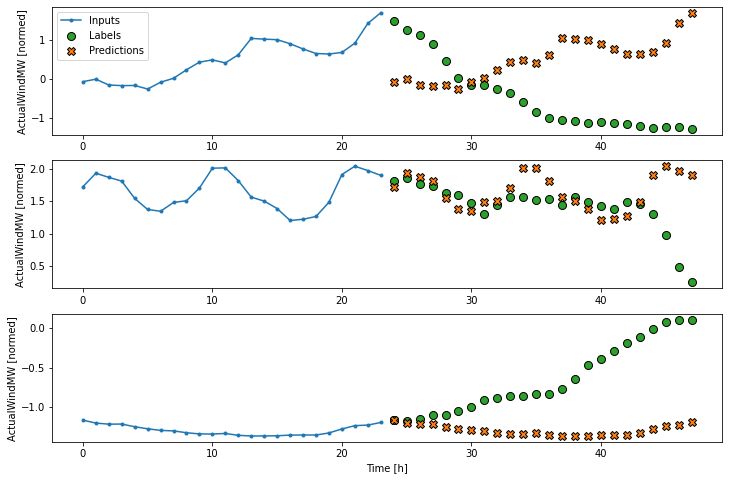

In [177]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

200/200 [==============================] - 1s 4ms/step - loss: 0.6008 - mean_absolute_error: 0.5348


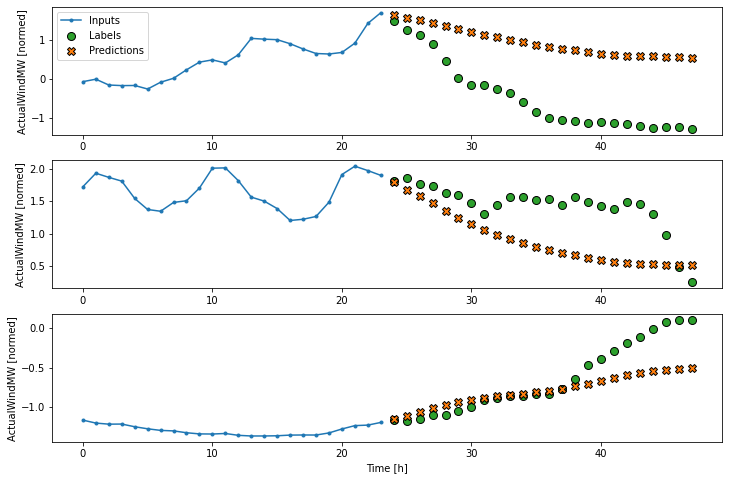

In [178]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

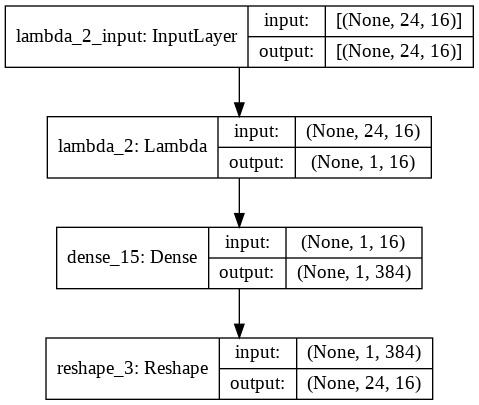

In [179]:
plot_model(multi_linear_model, to_file='multi_linear_model.png', show_shapes=True, show_layer_names=True)

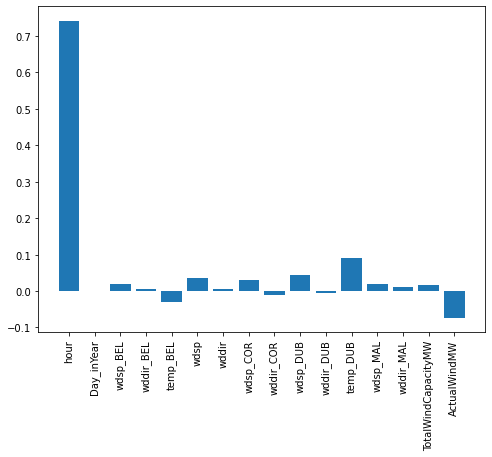

In [180]:
plt.bar(x = range(len(train_df.columns)),
        height=multi_linear_model.layers[1].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

#### Dense

Adding a `layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input timestep.

200/200 [==============================] - 1s 3ms/step - loss: 0.5350 - mean_absolute_error: 0.4911


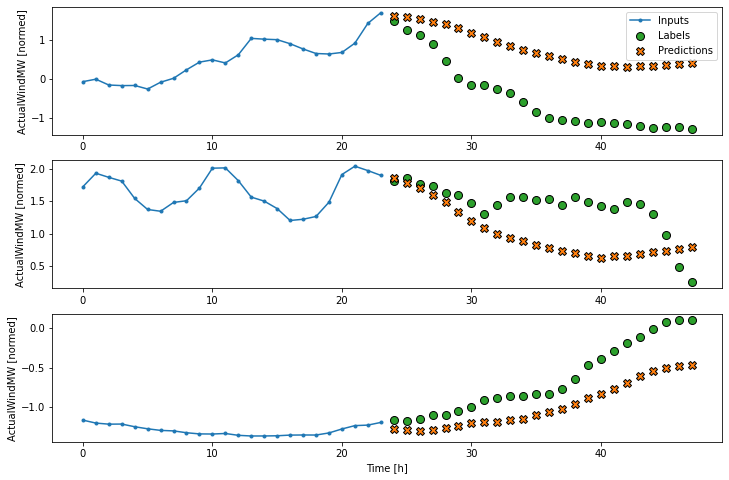

In [181]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

## RNN
A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False`.

200/200 [==============================] - 1s 4ms/step - loss: 0.5888 - mean_absolute_error: 0.5507


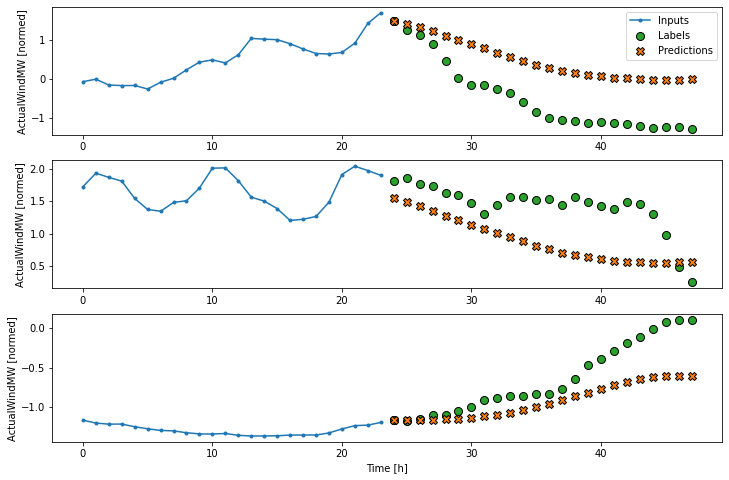

In [182]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### autoregressive RNN model
The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic [Generating Sequences With Recurrent Neural Networks](https://arxiv.org/abs/1308.0850).

In [183]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [184]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [185]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [186]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 16])

In [187]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [188]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 16)


200/200 [==============================] - 2s 8ms/step - loss: 0.6272 - mean_absolute_error: 0.5775


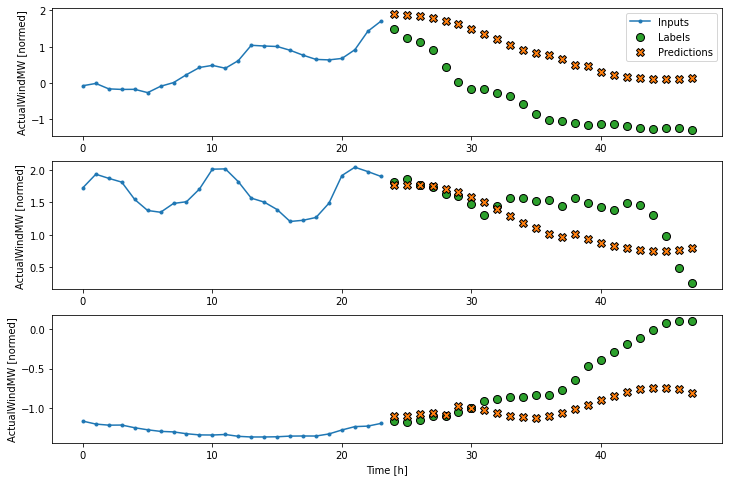

In [189]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

# Performance

In [190]:
test_df.shape

(3214, 16)

In [191]:
scaler = ct.named_transformers_['standardscaler']
scaler.inverse_transform(test_df)

array([[2.000000e+00, 2.920000e+02, 7.000000e+00, ..., 4.000000e+01,
        5.531095e+03, 1.090000e+03],
       [3.000000e+00, 2.920000e+02, 6.000000e+00, ..., 9.000000e+01,
        5.531095e+03, 1.056750e+03],
       [4.000000e+00, 2.920000e+02, 4.000000e+00, ..., 1.100000e+02,
        5.531095e+03, 1.019500e+03],
       ...,
       [2.100000e+01, 5.900000e+01, 5.000000e+00, ..., 2.000000e+02,
        5.531095e+03, 9.767500e+02],
       [2.200000e+01, 5.900000e+01, 3.000000e+00, ..., 1.600000e+02,
        5.531095e+03, 1.039250e+03],
       [2.300000e+01, 5.900000e+01, 4.000000e+00, ..., 1.500000e+02,
        5.531095e+03, 1.034000e+03]])

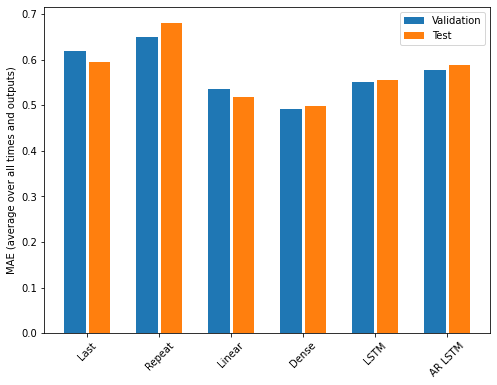

In [192]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [207]:
from datetime import tzinfo, timedelta, datetime, date

multi_performancePD = pd.DataFrame(multi_performance)
multi_performancePD = multi_performancePD.T
multi_performancePD.rename(columns={0 : 'normValMAE'}, inplace=True)
multi_performancePD.rename(columns={1 : 'normTestMAE'}, inplace=True)

multi_performancePD["ValMAE"] = multi_performancePD['normValMAE'] * np.sqrt(actualWindScaler.var_)
multi_performancePD["TestMAE"] = multi_performancePD['normTestMAE'] * np.sqrt(actualWindScaler.var_)
multi_performancePD

if not os.path.exists('Results'):
  os.mkdir('Results')

now = datetime.now()

multi_performancePD.to_csv("Results/TensorFlow" + str(now) + ".csv")

multi_performancePD

,normValMAE,normTestMAE,ValMAE,TestMAE
Last,0.868338,0.594591,806.758345,552.424579
Repeat,1.095750,0.681339,1018.042347,633.020454
Linear,0.567028,0.517404,526.816342,480.711503
Dense,0.541530,0.497620,503.126443,462.330577
LSTM,0.590388,0.554516,548.519900,515.191851
AR LSTM,0.642694,0.588911,597.115627,547.147586
